# Comparison of ARIMA and LSTM for time series forecasting
## Air pollution dataset

We compare the performance of traditional ARIMA models and Recurrent Neural Networks (LSTMs) for time series forecasting.



There are numerous ways of formulating a time series forecasting problem depending on the business scenario.

We simulate two scenarios. In both scenarios a time series model is trained and deployed, and we monitor its test performance over time. 
The model is not retrained during this testing phase.

1. **One-step moving origin forecasting**: 
 We produce a one-step forecast at each time step t and we observe a new data point that is added to the training dataset to compute the next step forecast. This is called 'moving origin' since we always observe a new data point at time t and thus the model is using only true historical data for every one-step forecast.

2. **Fixed origin forecasting:** Fixed origin means that the forecast we make at time step t will be added to the training dataset to compute the forecast at step t+1. This problem formulation is arguably more challenging than (1) as the model is using its own forecasts to generate further forecasts. 

Both monitoring strategies produce a sequence of one-step forecasts, which can be compared against the true test observations. 

As a measure of performance of the models, we use **MAPE** (mean absolute percentage error). 

In [ ]:
# install packages
!pip install statsmodels==0.12.1
!pip install sktime
!pip install pmdarima
!pip install tensorflow

# RESTART RUNTIME AFTER INSTALLATION 
exit()

     |████████████████████████████████| 9.5 MB 4.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 6.5 MB 3.9 MB/s 
     |████████████████████████████████| 3.3 MB 40.2 MB/s 
     |████████████████████████████████| 34.5 MB 12 kB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2
     |████████████████████████████████| 1.4 MB 3.2 MB/s 
     |████████████████████████████████| 462 kB 4.1 MB/s 


In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/Projects/Time-Series-ARIMA-vs-LSTM/Time-Series-ARIMA-vs-LSTM

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/Projects/Time-Series-ARIMA-vs-LSTM/Time-Series-ARIMA-vs-LSTM


# Data preprocessing

## Load data

We will use the [air pollution dataset](https://github.com/jankova/Time-Series-ARIMA-vs-LSTM/pollution_raw.csv). 
The dataset contains hourly measurements of different environmental variables including air pollution, temperature, pressure, dew point or wind direction. 

We will focus on forecasting pollution and consider two different approches:
1. univariate approach using only the time series pollution for training 
2. multivariate approach using all the available variables for training (called exogeneous variables).


In [ ]:
# basic imports
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# parse dates
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

dataset = pd.read_csv('pollution_raw.csv', 
                      parse_dates = [['year', 'month', 'day', 'hour']], 
                      index_col=0, 
                      date_parser=parse)

dataset.head()

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0


The list of variables in the dataset:
1. No: row number
2. year: year of data in this row
3. month: month of data in this row
4. day: day of data in this row
5. hour: hour of data in this row
6. pm2.5: PM2.5 concentration
7. DEWP: Dew Point
8. TEMP: Temperature
9. PRES: Pressure
10. cbwd: Combined wind direction
11. Iws: Cumulated wind speed
12. Is: Cumulated hours of snow
13. Ir: Cumulated hours of rain

## Basic preprocessing and missing data

In [ ]:
dataset.drop('No', axis=1, inplace=True)
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
dataset.info()

# fill all NA values with forward fill
dataset['pollution'].fillna(method = "ffill", inplace=True)

# drop the first 24 hours
dataset = dataset[24:]

# save to file
dataset.to_csv('pollution.csv')

# encoding categorical variables
wnd_dir_enc = pd.get_dummies(dataset["wnd_dir"], prefix="wnd_dir", prefix_sep='_', drop_first = True)

dataset = pd.concat([dataset.drop("wnd_dir", axis = 1), wnd_dir_enc], axis = 1)
dataset.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2010-01-01 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  41757 non-null  float64
 1   dew        43824 non-null  int64  
 2   temp       43824 non-null  float64
 3   press      43824 non-null  float64
 4   wnd_dir    43824 non-null  object 
 5   wnd_spd    43824 non-null  float64
 6   snow       43824 non-null  int64  
 7   rain       43824 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 3.0+ MB


,pollution,dew,temp,press,wnd_spd,snow,rain,wnd_dir_NW,wnd_dir_SE,wnd_dir_cv
date,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,1,0


## Exploratory plots

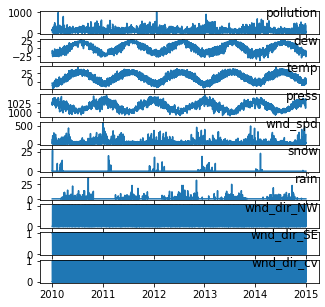

In [ ]:
import numpy as np

# specify columns to plot
cols = dataset.columns

# plot each column
plt.figure(figsize = (5,5))
for i, col in enumerate(cols):
	plt.subplot(len(cols), 1, i+1)
	plt.plot(dataset[col])
	plt.title(dataset.columns[i], y=0.5, loc='right')

plt.show()

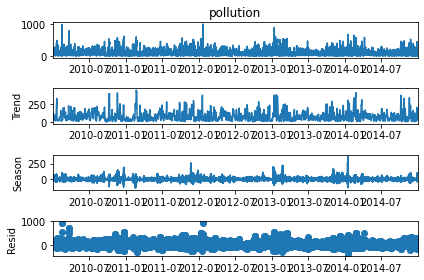

In [ ]:
# seasonal decomposition
response_var = "pollution"

from statsmodels.tsa.seasonal import seasonal_decompose, STL

stl = STL(dataset[response_var], seasonal = 7, robust = True)
stl.fit().plot()
plt.show()

## Create train data

In [ ]:
dataset.index = pd.date_range(start=dataset.index[0], 
                              end=dataset.index[-1], 
                              freq = 'H')


# take a subset of the full dataset
train_size = 10000
dataset_train = dataset.iloc[:train_size, :]



# ARIMA

## ARIMA exploratory analysis 


In [ ]:
# tests for stationarity
from statsmodels.tsa.stattools import adfuller, kpss

def stationarity_tests(df):
    # ADF (H0: unit root is present)
    res_adf = adfuller(df)
    print(f"p-value ADF: {res_adf[1]}")
    
    # KPSS (H0: stationary)
    statistic, p_value, n_lags, critical_values = kpss(df, nlags="auto")
    print(f"p-value KPSS: {p_value}")

stationarity_tests(dataset[response_var])    


p-value ADF: 0.0
p-value KPSS: 0.1


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


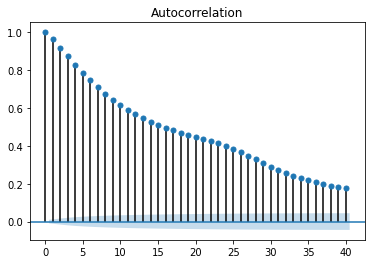

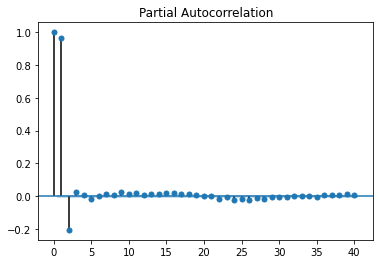

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(dataset[response_var], lags=40)
plot_pacf(dataset[response_var], lags=40)
plt.show()

## SARIMAX training

In [ ]:
from sktime.forecasting.model_selection import temporal_train_test_split

In [ ]:
# defining exogeneous variables
exo_train = dataset_train.drop([response_var], axis = 1)

y_train, y_test, X_train, X_test = temporal_train_test_split(dataset_train[response_var], 
                                                             exo_train, 
                                                             test_size=500)

In [ ]:
import itertools

# define parameters for grid search
p, d, q = range(2,3), [0], range(2,3)
P, D, Q, s = range(0,2), [0], range(0,2), [1]

pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
params_grid = list(itertools.product(pdq,seasonal_pdq))

In [ ]:
import statsmodels.api as sm
import pandas as pd

def optim_pars_SARIMA(params_grid, exo_train = pd.DataFrame({})):
    '''
    For each parameter combination in 'params_grid', fit a SARIMA model. Compute and return AICs.
    Optionally can add exogeneous variables. 
    '''
    AIC = []
    for param in params_grid:
        order = param[0]
        seasonal_order = param[1]

        #train.index = pd.DatetimeIndex(train.index.values,
        #                               freq=train.index.inferred_freq)

        if exo_train.empty:
            sar = sm.tsa.statespace.SARIMAX(endog = y_train,
                                            order = order#,
                                            #seasonal_order = seasonal_order
                                            )
        else:
            sar = sm.tsa.statespace.SARIMAX(endog = y_train,
                                            exog = X_train,
                                            order = order#,
                                            #seasonal_order = seasonal_order
                                            )
        res = sar.fit(disp=False)
        AIC.append((param, res.aic, res))

    return AIC


In [ ]:
# without exogeneous variables
AIC = optim_pars_SARIMA(params_grid)

AIC.sort(key = lambda x: x[1])

# optimal model according to AIC
print(f"\n Optimal model: parameters = {AIC[0]}")

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)



 Optimal model: parameters = (((2, 0, 2), (0, 0, 0, 1)), 88099.26939468898, <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x7f27d0b0f510>)


In [ ]:
# with exogeneous variables
AIC_exo = optim_pars_SARIMA(params_grid, exo_train)

AIC_exo.sort(key = lambda x: x[1])

# optimal model according to AIC
print(f"\n Optimal model: parameters = {AIC_exo[0]}")

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)



 Optimal model: parameters = (((2, 0, 2), (0, 0, 0, 1)), 88360.73692503785, <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x7f27dceabc10>)


## SARIMAX residuals check

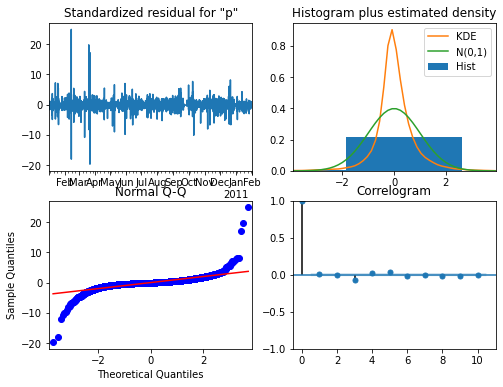

In [ ]:
# residual check
res_opt = AIC[0][2]
res_opt.plot_diagnostics(figsize = (8,6))
plt.show()

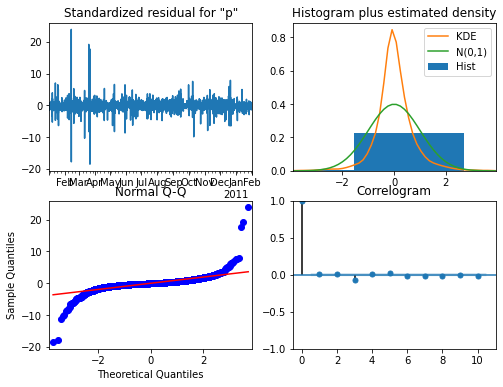

In [ ]:
# residual check
res_opt_exo = AIC_exo[0][2]
res_opt_exo.plot_diagnostics(figsize = (8,6))
plt.show()

## SARIMAX forecasts

In [ ]:
# fixed origin forecast

preds_arima = res_opt.predict(start = y_test.index[0], end = y_test.index[-1], dynamic=True)
preds_arima.shape

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


(500,)

In [ ]:
# moving origin one-step forecast
# to obtain moving origin forests, define a model on full dataset but then make predictions only 
# using the parameters from 'res.params' model

mod = sm.tsa.statespace.SARIMAX(dataset_train[response_var], order=AIC[0][0][0])
res_roll = mod.filter(res_opt.params)
preds_arima_moving = res_roll.predict()
preds_arima_moving = preds_arima_moving[y_test.index]


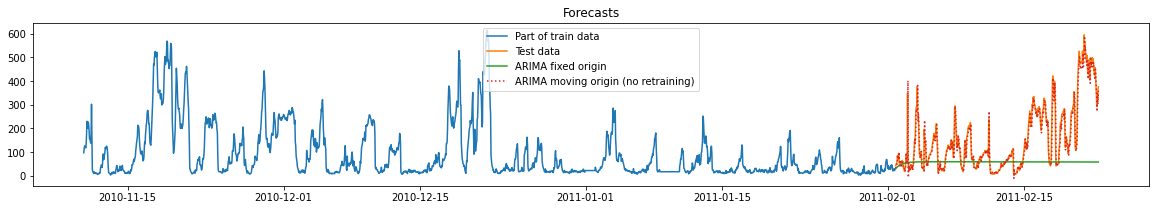

In [ ]:
# Forecast plots
plt.figure(figsize = (20, 3))
plt.plot(y_train[-2000:], label = "Part of train data")
plt.plot(y_test, label = "Test data")
plt.plot(preds_arima, label = "ARIMA fixed origin")
plt.plot(preds_arima_moving, label = "ARIMA moving origin (no retraining)", linestyle = ':')
plt.title("Forecasts")
plt.legend()


In [ ]:
# Comparison of MAPE 

from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE

print(f"Fixed origin ARIMA: {MAPE(preds_arima.values, y_test)}")
print(f"Moving origin ARIMA (no retraining): {MAPE(preds_arima_moving, y_test)}")

Fixed origin ARIMA: 1.9670593193451376
Moving origin ARIMA (no retraining): 0.21614920851822458


In [ ]:
# fixed origin forecast
preds_arima_exo = res_opt_exo.predict(start = y_test.index[0], end = y_test.index[-1], 
                                        dynamic = True, 
                                        exog = X_test
                                        )
preds_arima_exo.shape


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


(500,)

In [ ]:
# rolling origin forecast (no retraining)

mod = sm.tsa.statespace.SARIMAX(endog = dataset_train["pollution"], 
                                exog = dataset_train.drop("pollution", axis = 1), order=order)
res_roll_exo = mod.filter(res_opt_exo.params)
preds_arima_moving_exo = res_roll_exo.predict()
preds_arima_moving_exo = preds_arima_moving_exo[y_test.index]


## Evaluation of ARIMA models

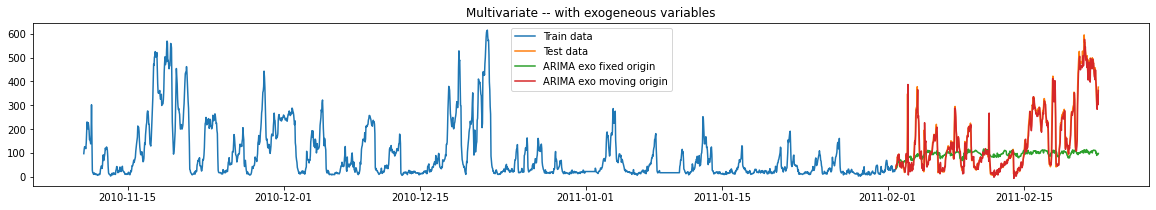

In [ ]:
plt.figure(figsize = (20, 3))
plt.plot(y_train[-2000:], label = "Train data")
plt.plot(y_test, label = "Test data")
plt.plot(preds_arima_exo, label = "ARIMA exo fixed origin")
plt.plot(preds_arima_moving_exo, label = "ARIMA exo moving origin")
plt.title("Multivariate -- with exogeneous variables")
plt.legend()

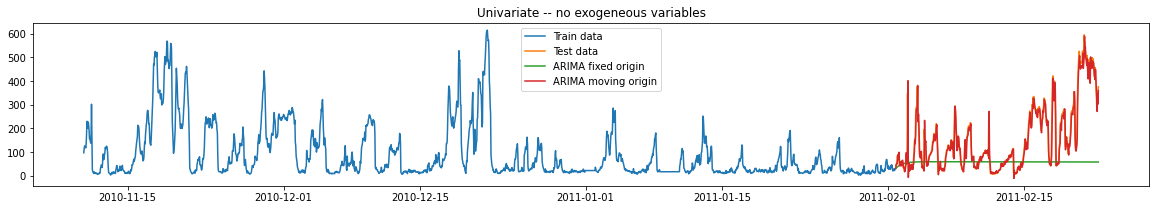

In [ ]:
plt.figure(figsize = (20, 3))
plt.plot(y_train[-2000:], label = "Train data")
plt.plot(y_test, label = "Test data")
plt.plot(preds_arima, label = "ARIMA fixed origin")
plt.plot(preds_arima_moving, label = "ARIMA moving origin")
plt.title("Univariate -- no exogeneous variables")

plt.legend()


In [ ]:
# comparison of MAPE errors

print(f"Fixed origin ARIMA: {MAPE(preds_arima, y_test)}")
print(f"Fixed origin ARIMA exo: {MAPE(preds_arima_exo, y_test)}")
print(f"Moving origin ARIMA: {MAPE(preds_arima_moving, y_test)}")
print(f"Moving origin ARIMA exo: {MAPE(preds_arima_moving_exo, y_test)}")

Fixed origin ARIMA: 1.9670593193451376
Fixed origin ARIMA exo: 1.011858442697494
Moving origin ARIMA: 0.21614920851822458
Moving origin ARIMA exo: 0.2486750967995414


In [ ]:
results_fixed_origin = []
results_fixed_origin.append(['SARIMAX', preds_arima, MAPE(preds_arima, y_test), MSE(preds_arima, y_test)])
results_fixed_origin.append(['SARIMAX exo', preds_arima_exo, MAPE(preds_arima_exo, y_test), MSE(preds_arima_exo, y_test)])

In [ ]:
results_moving_origin = []
results_moving_origin.append(['SARIMAX', preds_arima_moving, MAPE(preds_arima_moving, y_test), MSE(preds_arima_moving, y_test)])
results_moving_origin.append(['SARIMAX exo', preds_arima_moving_exo, MAPE(preds_arima_moving_exo, y_test), MSE(preds_arima_moving_exo, y_test)])

# LSTM and machine learning methods



## Conversion to supervised learning framework

To train LSTM, we convert the time series data to a supervised learning dataframe using a slicing window. 
In each supervised example, the features are the variable values at previous 'n_in' time steps and the response variable is pollution at the current time step. 


In [ ]:
from pandas import read_csv
from pandas import DataFrame
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, num_lags=1, num_predict_steps=1, dropnan=True):
    '''
    Transform a collection of time series into a dataframe suitable for supervised learning.
        data: a dataframe containing a number of time series
        num_lags: the number of lags to consider 
        n_out: the dimension of the output
        dropnan: True if drop NaN from final dataframe
    '''
    n_vars = data.shape[1]
    df = data.copy()

    cols, names = list(), list()
   
	  # input sequence (t-n, ... t-1)
    for i in range(num_lags, 0, -1):
        cols.append(df.shift(i))
        names += [f'{var_name}_t-{i}' for var_name in data.columns]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, num_predict_steps):
        cols.append(df.shift(-i))
        names += [f'{var_name}_t+{i}' for var_name in data.columns]

	  # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

	  # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
## scaling

#data = dataset_train.copy()

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1, 2, 3, 4, 7))
scaler_response = MinMaxScaler(feature_range=(0,1)).fit(dataset[[response_var]])
data_normalized = scaler.fit_transform(dataset)
data_normalized = pd.DataFrame(data_normalized, columns = dataset.columns, index = dataset.index)

n_features = data_normalized.shape[1]
n_features

n_in = 7

In [ ]:
# split into train and test

scaled_train, scaled_test = temporal_train_test_split(scaled, test_size = 0.1)


In [ ]:
# MULTIVARIATE MODELING 
# -- prepare data to perform 

# reframing train and test separately

response_name = "pollution"

scaled_train, scaled_test = temporal_train_test_split(scaled, test_size = 0.1)

reframed_train = series_to_supervised(scaled_train, n_in = n_in, n_out = 1, dropnan=True)
reframed_test = series_to_supervised(scaled_test, n_in = n_in, n_out = 1, dropnan=True)

drop_vars = [f'{var_name}_t+0' for var_name in data.columns]
drop_vars.remove(f'{response_name}_t+0')

# drop columns we don't want to predict
df_full_train = reframed_train.drop(drop_vars, axis = 1)
df_full_test = reframed_test.drop(drop_vars, axis = 1)

X_test = df_full_test.drop([f"{response_name}_t+0"], axis = 1)
y_test_n = df_full_test[f"{response_name}_t+0"]

X_train = df_full_train.drop([f"{response_name}_t+0"], axis = 1)
y_train_n = df_full_train[f"{response_name}_t+0"]


In [ ]:
# UNIVARIATE MODELING
#  -- only pollution time series used, no exogeneous variables

# reframing train and test separately

scaled_train_uni, scaled_test_uni = temporal_train_test_split(scaled[["pollution"]], test_size = 0.1)

reframed_train_uni = series_to_supervised(scaled_train_uni, n_in = n_in, n_out = 1, dropnan=True)
reframed_test_uni = series_to_supervised(scaled_test_uni, n_in = n_in, n_out = 1, dropnan=True)

X_test_uni = reframed_test_uni.drop([f"{response_name}_t+0"], axis = 1)
y_test_n_uni = reframed_test_uni[f"{response_name}_t+0"]

X_train_uni = reframed_train_uni.drop([f"{response_name}_t+0"], axis = 1)
y_train_n_uni = reframed_train_uni[f"{response_name}_t+0"]

In [ ]:
# MULTIVARIATE MODELING 
# -- prepare data to perform supervised learning

# reframing train and test separately

def reframe_data(scaled_train, scaled_test, num_lags, num_predict_steps):
    '''
    Reframe data using slicing window to use in a supervised learning framework. 
    '''
    #response_var = "kWh"

    reframed_train = series_to_supervised(scaled_train, num_lags = num_lags, num_predict_steps = num_predict_steps, dropnan=True)
    reframed_test = series_to_supervised(scaled_test, num_lags = num_lags, num_predict_steps = num_predict_steps, dropnan=True)

    # drop_vars = [f'{var_name}_t+0' for var_name in data.columns]
    drop_vars = []
    for i in range(num_predict_steps):
        drop_vars += [f'{var_name}_t+{i}' for var_name in scaled_train.columns if var_name != response_var]

    #drop_vars.remove(f'{response_name}_t+0')

    # drop columns we don't want to predict
    df_full_train = reframed_train.drop(drop_vars, axis = 1)
    df_full_test = reframed_test.drop(drop_vars, axis = 1)

    drop_responses = [f"{response_var}_t+{i}" for i in range(num_predict_steps)]

    X_test = df_full_test.drop(drop_responses, axis = 1)
    y_test_n = df_full_test[drop_responses]

    X_train = df_full_train.drop(drop_responses, axis = 1)
    y_train_n = df_full_train[drop_responses]

    return X_train, y_train_n, X_test, y_test_n



In [ ]:
train_size = 10000
train_end = 9500

# using exogeneous variables
dataset_reduced = data_normalized[:train_size]

# without exogeneous variables
dataset_reduced_uni = data_normalized[[response_var]][:train_size]

n_features = dataset_reduced.shape[1]
n_features_uni = dataset_reduced_uni.shape[1]
num_lags = 10
num_predict_steps = 1

print(f"n_features: {n_features}, num_lags: {num_lags}, num_predict_steps: {num_predict_steps}")

train, test = dataset[:train_end][response_var], dataset[train_end:][response_var]
scaled_train, scaled_test = dataset_reduced[:train_end], dataset_reduced[train_end:]

scaled_train_uni, scaled_test_uni = dataset_reduced_uni[:train_end], dataset_reduced_uni[train_end:]

X_train, y_train_n, X_test, y_test_n = reframe_data(scaled_train, scaled_test, num_lags, num_predict_steps)

X_train_uni, y_train_n, X_test_uni, y_test_n = reframe_data(scaled_train_uni, scaled_test_uni, num_lags, num_predict_steps)


n_features: 10, num_lags: 10, num_predict_steps: 1


## Baseline: Random forest

In [ ]:
def rescale(y_pred, index):
    '''
    Rescale predictions back to original scale.
    '''
    y_pred_rescaled = scaler_response.inverse_transform(y_pred.reshape(-1,1)).flatten()
    y_pred_rescaled = pd.Series(y_pred_rescaled, index = index)

    return y_pred_rescaled

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Mean absolute percentage error: 0.22
Root mean squared error: 48.78


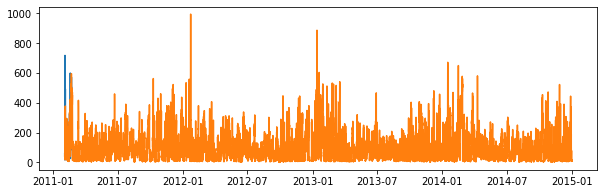

In [ ]:
# train with exogeneous variables

import numpy as np
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

rf.fit(X_train, y_train_n)
y_pred_rf = rf.predict(X_test)
y_pred_rf_rescaled = rescale(y_pred_rf, y_test_n.index) #pd.Series(y_pred_rf_rescaled[:,0], index = y_test_n.index)

y_test_rescaled = rescale(y_test_n.values, y_test_n.index)

plt.figure(figsize = (10,3))
plt.plot(y_pred_rf_rescaled)
plt.plot(y_test_rescaled)

err = 'Mean absolute percentage error: %.2f'% MAPE(y_test_rescaled, y_pred_rf_rescaled) + \
'\nRoot mean squared error: %.2f'% np.sqrt(MSE(y_test_rescaled, y_pred_rf_rescaled))

print(err)

In [ ]:
X_train.shape

(9490, 100)

## LSTM training


In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense


In [ ]:
# reshape data to 3D-shape expected by LSTMs: [samples, timesteps, features]
import numpy as np

X_train_scaled_3d = np.array(X_train).reshape((X_train.shape[0], num_lags, n_features))
print(X_train_scaled_3d.shape)

X_test_scaled_3d = np.array(X_test).reshape((X_test.shape[0], num_lags, n_features))
print(X_test_scaled_3d.shape)

X_train_scaled_3d_uni = np.array(X_train_uni).reshape((X_train_uni.shape[0], num_lags, n_features_uni))
X_test_scaled_3d_uni = np.array(X_test_uni).reshape((X_test_uni.shape[0], num_lags, n_features_uni))

(9490, 10, 10)
(490, 10, 10)


Epoch 1/100
132/132 - 7s - loss: 0.0401 - val_loss: 0.0663 - 7s/epoch - 53ms/step
Epoch 2/100
132/132 - 2s - loss: 0.0315 - val_loss: 0.0535 - 2s/epoch - 15ms/step
Epoch 3/100
132/132 - 2s - loss: 0.0269 - val_loss: 0.0467 - 2s/epoch - 15ms/step
Epoch 4/100
132/132 - 2s - loss: 0.0239 - val_loss: 0.0399 - 2s/epoch - 15ms/step
Epoch 5/100
132/132 - 2s - loss: 0.0214 - val_loss: 0.0347 - 2s/epoch - 14ms/step
Epoch 6/100
132/132 - 2s - loss: 0.0191 - val_loss: 0.0292 - 2s/epoch - 14ms/step
Epoch 7/100
132/132 - 2s - loss: 0.0173 - val_loss: 0.0245 - 2s/epoch - 14ms/step
Epoch 8/100
132/132 - 2s - loss: 0.0156 - val_loss: 0.0225 - 2s/epoch - 15ms/step
Epoch 9/100
132/132 - 2s - loss: 0.0143 - val_loss: 0.0211 - 2s/epoch - 15ms/step
Epoch 10/100
132/132 - 2s - loss: 0.0135 - val_loss: 0.0205 - 2s/epoch - 14ms/step
Epoch 11/100
132/132 - 2s - loss: 0.0132 - val_loss: 0.0208 - 2s/epoch - 15ms/step
Epoch 12/100
132/132 - 2s - loss: 0.0132 - val_loss: 0.0203 - 2s/epoch - 14ms/step
Epoch 13/100


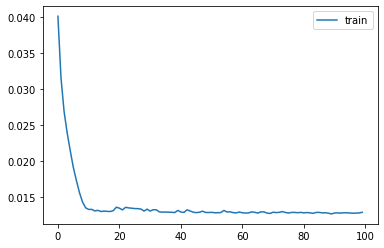

In [ ]:
def get_lstm_model(input):

    # network architecture
    model_lstm = Sequential()
    model_lstm.add(LSTM(50, return_sequences=True, 
                        input_shape=(input[1], input[2])))
    model_lstm.add(LSTM(50, activation='relu'))
    model_lstm.add(Dense(num_predict_steps))
    model_lstm.compile(loss='mae', optimizer='adam')

    return model_lstm

# model with no exogeneous variables
model_lstm = get_lstm_model(X_train_scaled_3d_uni.shape)

# model with exogeneous variables
model_lstm_exo = get_lstm_model(X_train_scaled_3d.shape)

# training without exogeneous variables
history_uni = model_lstm.fit(X_train_scaled_3d_uni, y_train_n, 
                    epochs=100, 
                    batch_size=72, 
                    validation_data=(X_test_scaled_3d_uni, y_test_n), 
                    verbose=2, 
                    shuffle=False)
# plot history
plt.plot(history_uni.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


Epoch 1/100
132/132 - 5s - loss: 0.0501 - 5s/epoch - 40ms/step
Epoch 2/100
132/132 - 2s - loss: 0.0352 - 2s/epoch - 14ms/step
Epoch 3/100
132/132 - 2s - loss: 0.0319 - 2s/epoch - 14ms/step
Epoch 4/100
132/132 - 2s - loss: 0.0302 - 2s/epoch - 14ms/step
Epoch 5/100
132/132 - 2s - loss: 0.0278 - 2s/epoch - 14ms/step
Epoch 6/100
132/132 - 2s - loss: 0.0262 - 2s/epoch - 14ms/step
Epoch 7/100
132/132 - 2s - loss: 0.0248 - 2s/epoch - 14ms/step
Epoch 8/100
132/132 - 2s - loss: 0.0227 - 2s/epoch - 14ms/step
Epoch 9/100
132/132 - 2s - loss: 0.0205 - 2s/epoch - 14ms/step
Epoch 10/100
132/132 - 2s - loss: 0.0193 - 2s/epoch - 15ms/step
Epoch 11/100
132/132 - 2s - loss: 0.0177 - 2s/epoch - 14ms/step
Epoch 12/100
132/132 - 2s - loss: 0.0167 - 2s/epoch - 14ms/step
Epoch 13/100
132/132 - 2s - loss: 0.0165 - 2s/epoch - 14ms/step
Epoch 14/100
132/132 - 2s - loss: 0.0151 - 2s/epoch - 15ms/step
Epoch 15/100
132/132 - 2s - loss: 0.0150 - 2s/epoch - 15ms/step
Epoch 16/100
132/132 - 2s - loss: 0.0145 - 2s/epo

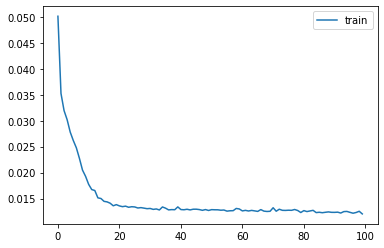

In [ ]:
# training with exogeneous variables
history = model_lstm_exo.fit(X_train_scaled_3d, y_train_n, 
                    epochs=100, 
                    batch_size=72, 
                    #validation_data=(X_test_scaled_3d, y_test_n), 
                    verbose=2, 
                    shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## LSTM forecasts

In [ ]:
def get_lstm_predictions(model_lstm, test_data):
    '''
    Return model predictions on test_data, rescaled to original scale.
    '''
    preds_lstm = model_lstm.predict(test_data).flatten()
    # rescale predictions to original scale
    preds_lstm_rescaled = rescale(preds_lstm, index = y_test_n.index)

    return preds_lstm_rescaled

# rescale y_test to original scale (for latter plotting)
y_test_rescaled = rescale(np.array(y_test_n), index = y_test_n.index)

# compute onestep moving origin predictions, with exogeneous variables
preds_lstm_rescaled = get_lstm_predictions(model_lstm_exo, X_test_scaled_3d)

# compute onestep moving origin predictions, no exogeneous variables
preds_lstm_rescaled = get_lstm_predictions(model_lstm, X_test_scaled_3d_uni)


In [ ]:
# compute one-step fixed origin predictions, no exogeneous variables
import datetime
from tqdm import tqdm

def onestep_fixed(model):
    '''
    Create one-step fixed predictions for lstm model. 
    Only implemented for univariate case (i.e. no exgoenegous variables).
    '''
    preds = []
    X0 = X_test_uni.iloc[0]
    date = X_test_uni.index[0]

    dates = []
    
    X0_3d_update = np.array(X0).reshape((1, num_lags, n_features_uni))

    for i in tqm(range(X_test.shape[0])):
        preds_lstm_one = model.predict(X0_3d_update).flatten()

        # update with new onestep forecast
        X0_3d_update = np.append(X0_3d_update[0][1:], preds_lstm_one)
        X0_3d_update = np.array(X0_3d_update).reshape((1, num_lags, n_features_uni))
        preds.append(preds_lstm_one[0])
        date += datetime.timedelta(hours=1)
        dates.append(date)

    return pd.Series(preds, index = dates)

preds_onestep_fixed = onestep_fixed(model_lstm)
preds_onestep_fixed = rescale(preds_onestep_fixed.values, preds_onestep_fixed.index)


In [ ]:
results_moving_origin.append(['LSTM', preds_lstm_rescaled,
                              MAPE(y_test_rescaled, preds_lstm_rescaled),
                              np.sqrt(MSE(y_test_rescaled, preds_lstm_rescaled))])


results_fixed_origin.append(['LSTM', preds_onestep_fixed, 
                              MAPE(y_test_rescaled, preds_onestep_fixed),
                              MSE(y_test_rescaled, preds_onestep_fixed)])

Mean absolute percentage error: 0.20
Root mean squared error: 34.46


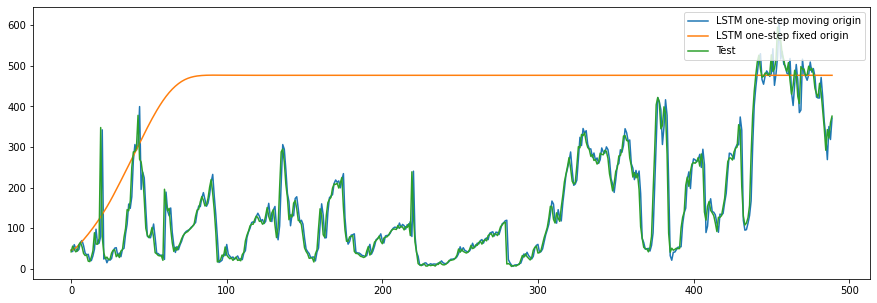

In [ ]:
plt.figure(figsize = (15,5))
plt.plot(np.array(preds_lstm_rescaled.values), label = "LSTM one-step moving origin")
plt.plot(np.array(preds_onestep_fixed.values), label = "LSTM one-step fixed origin")
plt.plot(np.array(y_test_rescaled), label = "Test")
plt.legend(loc = 'upper right')

err = 'Mean absolute percentage error: %.2f'% MAPE(y_test_rescaled, preds_lstm_rescaled) + \
'\nRoot mean squared error: %.2f'% np.sqrt(MSE(y_test_rescaled, preds_lstm_rescaled))

print(err)

## One-step moving origin scenario

One-step moving forecasts


,MAPE
Model Name,
SARIMAX,0.216149
SARIMAX exo,0.248675
LSTM,0.198253


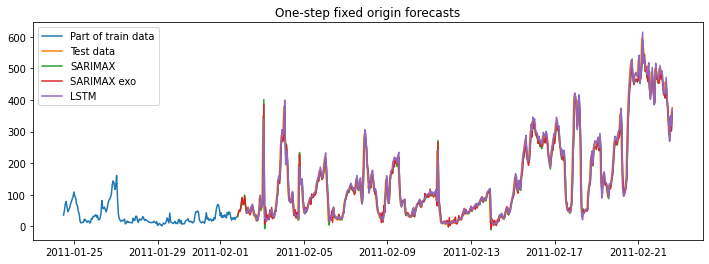

In [ ]:
# plots
print("One-step moving forecasts")
names, MAPEs = [], []

plt.figure(figsize = (12, 4))
plt.title("One-step fixed origin forecasts")
plt.plot(train[-200:], label = "Part of train data")
plt.plot(y_test_rescaled, label = "Test data")

for item in results_moving_origin:
    names.append(item[0])
    MAPEs.append(item[2])
    plt.plot(item[1], label = item[0])

plt.legend(loc = "upper left")

comparison_moving = pd.DataFrame({'Model Name': names, 'MAPE': MAPEs})
comparison_moving = comparison_moving.set_index('Model Name')
comparison_moving

## One-step fixed origin scenario

One-step fixed origin forecasts


,MAPE
Model Name,
SARIMAX,1.967059
SARIMAX exo,1.011858
LSTM,6.958665


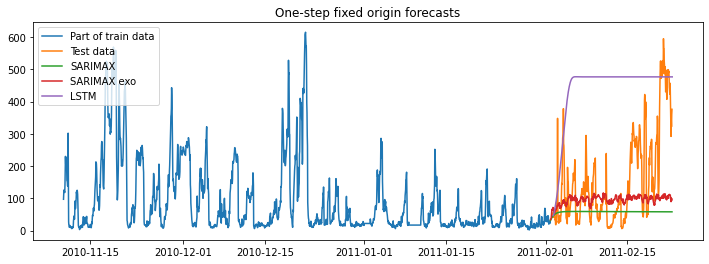

In [ ]:
print("One-step fixed origin forecasts")

names, MAPEs = [], []

plt.figure(figsize = (12, 4))
plt.title("One-step fixed origin forecasts")
plt.plot(train[-2000:], label = "Part of train data")
plt.plot(y_test_rescaled, label = "Test data")

for item in results_fixed_origin:
    names.append(item[0])
    MAPEs.append(item[2])
    plt.plot(item[1], label = item[0])

plt.legend(loc = "upper left")

comparison_fixed = pd.DataFrame({'Model Name': names, 'MAPE': MAPEs})
comparison_fixed = comparison_fixed.set_index('Model Name')
comparison_fixed